## Setup

In [1]:
!pip install numpy
!pip install pandas
!pip install statsmodels

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Specify project directories in Sherlock
data_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/data/'
results_path = '/oak/stanford/groups/mrivas/projects/wgs-constraint-llm/osthoag/wgs-constraint-llm/results/'

# Specify the file paths
alpha_missense_file_path = data_path + 'AlphaMissense_hg38.tsv.gz'
hmm_predictions_path = results_path + 'HMM_rgc_0.9_over20_chr2_predictions_rgc_wgs.tsv.gz'

## Load data

In [3]:
# Read the file into a pandas DataFrame
alpha_missense_df = pd.read_csv(alpha_missense_file_path, sep='\t', header=3)#, nrows=20)

# Rename columns to standard labels
alpha_missense_df.rename(columns={"#CHROM": "chr", "POS": "pos", "REF": "ref", "ALT": 'alt'}, inplace=True)

# Extract 'transcript' and 'num' from transcript_id
alpha_missense_df[['transcript', 'transcript_num']] = alpha_missense_df['transcript_id'].str.split('.', expand=True)
alpha_missense_df

,chr,pos,ref,alt,genome,uniprot_id,transcript_id,protein_variant,am_pathogenicity,am_class,transcript,transcript_num
0,chr1,69094,G,T,hg38,Q8NH21,ENST00000335137.4,V2L,0.2937,likely_benign,ENST00000335137,4
1,chr1,69094,G,C,hg38,Q8NH21,ENST00000335137.4,V2L,0.2937,likely_benign,ENST00000335137,4
2,chr1,69094,G,A,hg38,Q8NH21,ENST00000335137.4,V2M,0.3296,likely_benign,ENST00000335137,4
3,chr1,69095,T,C,hg38,Q8NH21,ENST00000335137.4,V2A,0.2609,likely_benign,ENST00000335137,4
4,chr1,69095,T,A,hg38,Q8NH21,ENST00000335137.4,V2E,0.2922,likely_benign,ENST00000335137,4
...,...,...,...,...,...,...,...,...,...,...,...,...
71697551,chrY,57196925,T,G,hg38,Q01113,ENST00000244174.10_PAR_Y,F521C,0.1903,likely_benign,ENST00000244174,10_PAR_Y
71697552,chrY,57196925,T,C,hg38,Q01113,ENST00000244174.10_PAR_Y,F521S,0.2045,likely_benign,ENST00000244174,10_PAR_Y
71697553,chrY,57196925,T,A,hg38,Q01113,ENST00000244174.10_PAR_Y,F521Y,0.1440,likely_benign,ENST00000244174,10_PAR_Y
71697554,chrY,57196926,C,G,hg38,Q01113,ENST00000244174.10_PAR_Y,F521L,0.5879,likely_pathogenic,ENST00000244174,10_PAR_Y


In [4]:
# Get predictions from HMM
predictions_df = pd.read_csv(hmm_predictions_path, sep='\t')

# Group by 'chr' and 'pos' and find the maximum 'am_pathogenicity' value
alpha_missense_grouped_df = alpha_missense_df.groupby(['chr', 'pos'])['am_pathogenicity'].max().reset_index()
merged_df = pd.merge(predictions_df, alpha_missense_grouped_df, on=['chr', 'pos'], how='inner')

# Write merged_df to a csv to repeat analysis in R
merged_df.to_csv(results_path + "constraint_am_results.tsv.gz", index=False, compression='gzip', sep='\t')

merged_df

,chr,pos,prob_0,prob_1,observation,am_pathogenicity
0,chr1,925945,0.009863,0.990137,0.0,0.8999
1,chr1,925946,0.000050,0.999950,1.0,0.9876
2,chr1,925948,0.000040,0.999960,1.0,0.9460
3,chr1,925949,0.000040,0.999960,1.0,0.9839
4,chr1,925950,0.000040,0.999960,1.0,0.9857
...,...,...,...,...,...,...
23005993,chr22,50777974,0.010142,0.989858,0.0,0.9569
23005994,chr22,50777975,0.000050,0.999950,1.0,0.6980
23005995,chr22,50777976,0.000072,0.999928,1.0,0.9584
23005996,chr22,50777977,0.032259,0.967741,1.0,0.2675


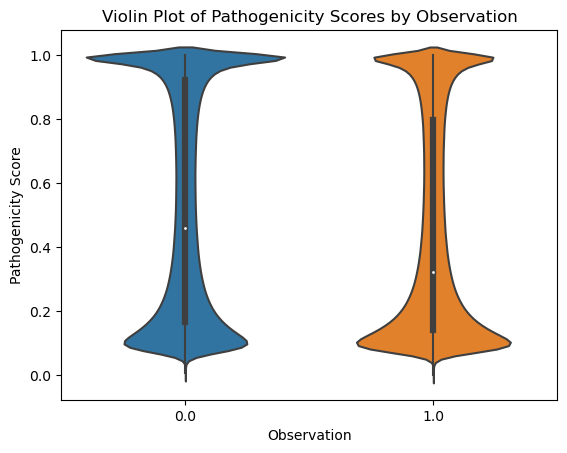

In [17]:
sns.violinplot(x='observation', y='am_pathogenicity', data=merged_df)
plt.xlabel('Observation')
plt.ylabel('Pathogenicity Score')
plt.title('Violin Plot of Pathogenicity Scores by Observation')
plt.show()

In [5]:
X = merged_df['am_pathogenicity']
X = sm.add_constant(X)
y = merged_df['prob_0']

# Fit the logistic regression model
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 prob_0   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                 3.009e+05
Date:                Thu, 14 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:00:22   Log-Likelihood:            -5.8794e+06
No. Observations:            23005998   AIC:                         1.176e+07
Df Residuals:                23005996   BIC:                         1.176e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1440      0.000  

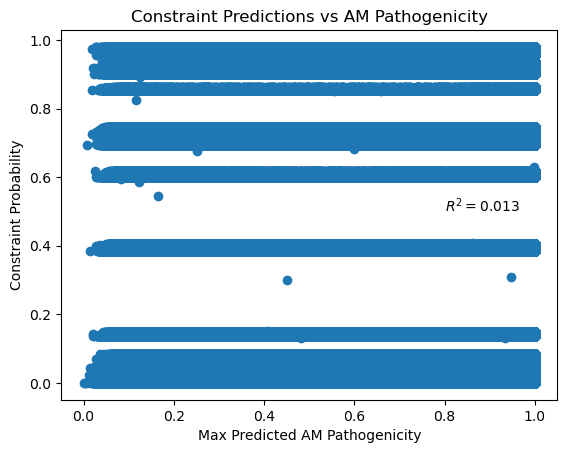

In [9]:
from matplotlib.colors import LinearSegmentedColormap
import mpl_scatter_density

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

plt.scatter(merged_df['am_pathogenicity'], merged_df['prob_0'])
plt.xlabel('Max Predicted AM Pathogenicity')
plt.ylabel('Constraint Probability')
# ax.set_xlim([0, 0.5])  # Adjust xlim if needed
# ax.set_ylim([-10, 10])   # Adjust ylim if needed
plt.title('Constraint Predictions vs AM Pathogenicity')
plt.text(0.8, 0.5, '$R^2=0.013$', fontsize=10)
plt.show()

## Run Binomial GLM with different combinations of pathogenicity, prob_0, and constant

In [6]:
X = merged_df[['am_pathogenicity', 'prob_0']]
X = sm.add_constant(X)
y = merged_df['observation']

# Fit the logistic regression model
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()

print(model.pseudo_rsquared('McFadden'))
print(model.summary())

0.3846228224010675
                 Generalized Linear Model Regression Results                  
Dep. Variable:            observation   No. Observations:             25248592
Model:                            GLM   Df Residuals:                 25248589
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0690e+07
Date:                Thu, 15 Feb 2024   Deviance:                   2.1380e+07
Time:                        22:13:13   Pearson chi2:                 1.76e+07
No. Iterations:                    10   Pseudo R-squ. (CS):             0.4110
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                

In [12]:
X = merged_df[['am_pathogenicity', 'prob_0']]
y = merged_df['observation']

# Fit the logistic regression model
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()

print(model.pseudo_rsquared('McFadden'))
print(model.summary())

0.3348727140994401
                 Generalized Linear Model Regression Results                  
Dep. Variable:            observation   No. Observations:             25248592
Model:                            GLM   Df Residuals:                 25248590
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1554e+07
Date:                Thu, 15 Feb 2024   Deviance:                   2.3109e+07
Time:                        22:29:46   Pearson chi2:                 1.80e+07
No. Iterations:                    10   Pseudo R-squ. (CS):             0.3692
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
am_pathogenicity     

In [7]:
X = merged_df['am_pathogenicity']
y = merged_df['observation']

# Fit the logistic regression model
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()

print(model.pseudo_rsquared('McFadden'))
print(model.summary())

0.00752481687874873
                 Generalized Linear Model Regression Results                  
Dep. Variable:            observation   No. Observations:             25248592
Model:                            GLM   Df Residuals:                 25248591
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.7241e+07
Date:                Thu, 15 Feb 2024   Deviance:                   3.4482e+07
Time:                        22:15:43   Pearson chi2:                 2.52e+07
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01030
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
am_pathogenicity    

In [8]:
X = merged_df['prob_0']
y = merged_df['observation']

# Fit the logistic regression model
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()

print(model.pseudo_rsquared('McFadden'))
print(model.summary())

0.2909505232400059
                 Generalized Linear Model Regression Results                  
Dep. Variable:            observation   No. Observations:             25248592
Model:                            GLM   Df Residuals:                 25248591
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2317e+07
Date:                Thu, 15 Feb 2024   Deviance:                   2.4635e+07
Time:                        22:18:50   Pearson chi2:                 1.82e+07
No. Iterations:                    10   Pseudo R-squ. (CS):             0.3299
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
prob_0       -15.4917      0.015 

In [9]:
y = merged_df['observation']
X = sm.add_constant(np.ones_like(y))

# Fit the logistic regression model
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()

print(model.pseudo_rsquared('McFadden'))
print(model.summary())

-3.552713678800501e-15
                 Generalized Linear Model Regression Results                  
Dep. Variable:            observation   No. Observations:             25248592
Model:                            GLM   Df Residuals:                 25248591
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.7372e+07
Date:                Thu, 15 Feb 2024   Deviance:                   3.4743e+07
Time:                        22:20:43   Pearson chi2:                 2.52e+07
No. Iterations:                     5   Pseudo R-squ. (CS):         -5.107e-15
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2030      0.

In [10]:
X = merged_df['prob_0']
X = sm.add_constant(X)
y = merged_df['observation']

# Fit the logistic regression model
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()

print(model.pseudo_rsquared('McFadden'))
print(model.summary())

0.38342064958303146
                 Generalized Linear Model Regression Results                  
Dep. Variable:            observation   No. Observations:             25248592
Model:                            GLM   Df Residuals:                 25248590
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0711e+07
Date:                Thu, 15 Feb 2024   Deviance:                   2.1422e+07
Time:                        22:24:19   Pearson chi2:                 1.75e+07
No. Iterations:                    11   Pseudo R-squ. (CS):             0.4100
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0379      0.001

In [11]:
X = merged_df['am_pathogenicity']
X = sm.add_constant(X)
y = merged_df['observation']

# Fit the logistic regression model
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()

print(model.pseudo_rsquared('McFadden'))
print(model.summary())

0.008068397398393157
                 Generalized Linear Model Regression Results                  
Dep. Variable:            observation   No. Observations:             25248592
Model:                            GLM   Df Residuals:                 25248590
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.7231e+07
Date:                Thu, 15 Feb 2024   Deviance:                   3.4463e+07
Time:                        22:26:24   Pearson chi2:                 2.52e+07
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01104
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              